In [3]:
# !pip install git+https://github.com/lucasb-eyer/pydensecrf.git
# !pip install scikit-image

In [104]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, unary_from_softmax
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm

In [105]:
def decode(rle_mask):
    # print(rle_mask)
    mask = rle_mask.split()
    # print(len(mask))
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)


def encode(im):
    pixels = im.flatten()
    return ' '.join(str(x) for x in pixels)

In [263]:
def crf(original_image, mask_img):
    
    labels = mask_img.flatten()

    # print(len(labels))
    n_labels = 11
    
    #Setting up the CRF model
    
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)
    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(1,1), compat=5, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    # print(original_image)
    # print(original_image.shape)
    d.addPairwiseBilateral(sxy=(6,6), srgb=(40,40,40), rgbim=original_image, compat=5)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [264]:
image_pth = r"C:\Users\onefe\Desktop\P_Stage\level2_p_segmentation\input\data\\"
csv_file = r"C:\Users\onefe\Desktop\P_Stage\level2_p_segmentation\output_Kmg.csv"
df = pd.read_csv(csv_file)

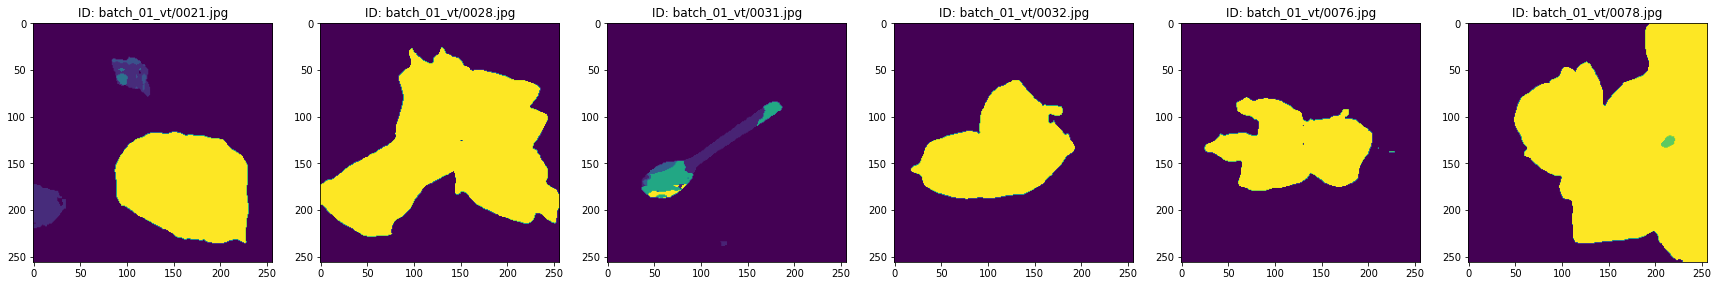

In [265]:
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'image_id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

batch_02_vt/0872.jpg
batch_02_vt/0887.jpg
batch_02_vt/0896.jpg
batch_02_vt/0901.jpg
batch_02_vt/0908.jpg
batch_02_vt/0911.jpg
batch_02_vt/0922.jpg
batch_02_vt/0950.jpg


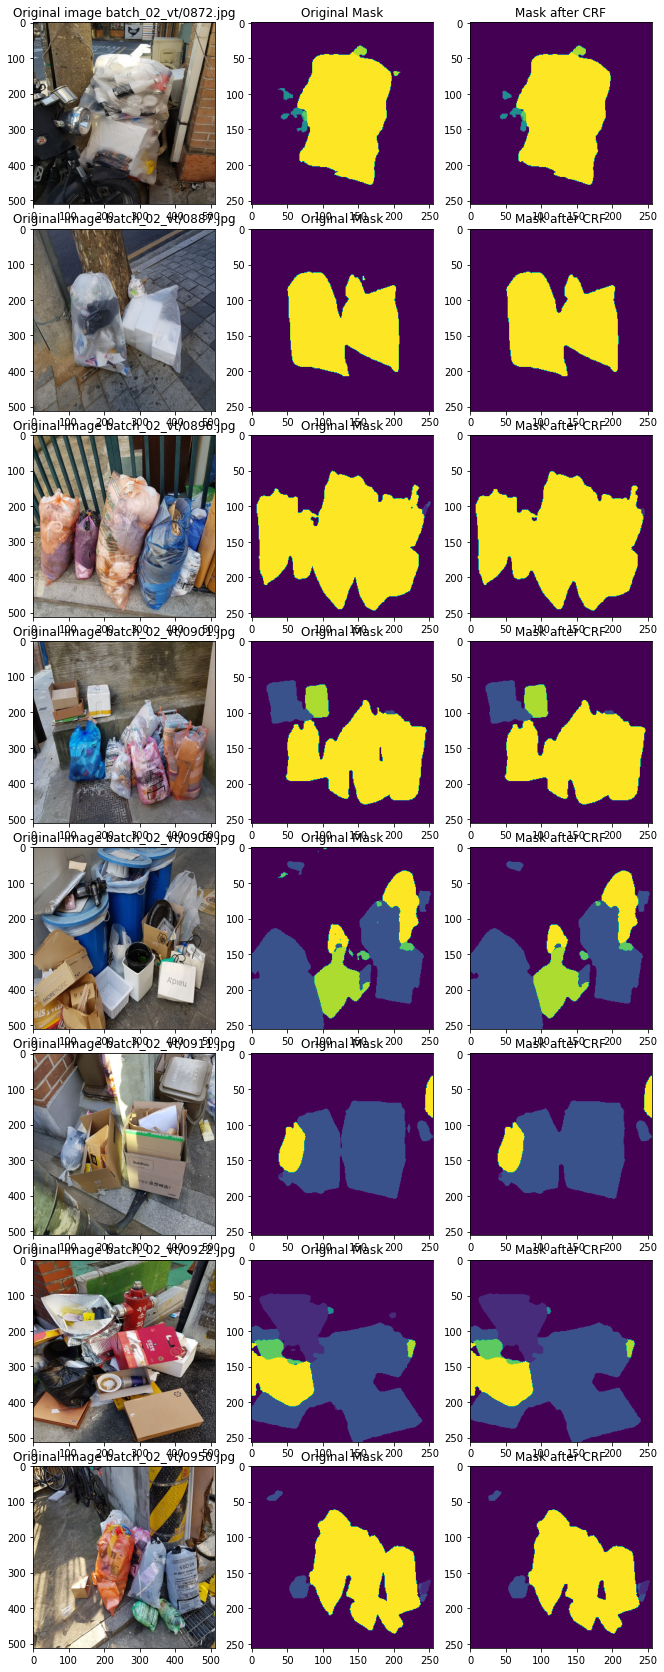

In [267]:
nImgs = 8
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,30))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        print(df.loc[i,'image_id'])
        decoded_mask = decode(df.loc[i,'PredictionString'])        
        orig_img2 = cv2.imread(image_pth+df.loc[i,'image_id'])
        orig_img2.resize(256,256, 3)
        #Applying CRF on FCN-16 annotated image
        plt.subplot(nImgs,4,4*j-3)
        crf_output = crf(orig_img2, decoded_mask)
        orig_img = cv2.imread(image_pth+df.loc[i,'image_id'])
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB).astype(np.float32)
        orig_img /= 255.0
        plt.imshow(orig_img)
        plt.title(f"Original image {df.loc[i,'image_id']}")
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1
